In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

In [2]:
cmap = 'tab20'

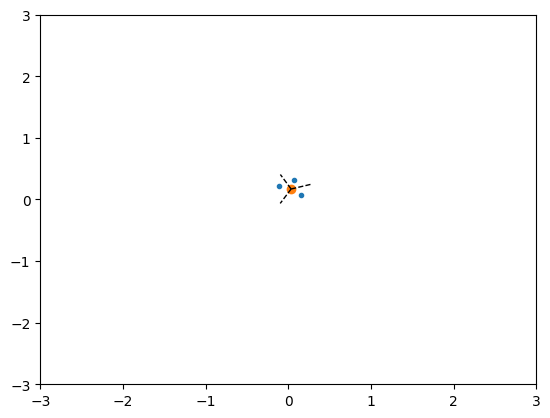

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d
np.random.seed(0)
num_cells = 3
cell_labels = np.arange(num_cells) + 1
vornoi_points = np.random.uniform(-.75,.75,(num_cells,2))
vor = Voronoi(vornoi_points)
voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [4]:
def find_label(x,y):
    if np.abs(x) > 2 or np.abs(y) > 2:
        return 0
    index = np.argmin((vornoi_points[:,0]-np.asarray(x))**2 + (vornoi_points[:,1]-np.asarray(y))**2)
    return cell_labels[index]

In [5]:
def data_fn(x,y):
    out = []
    print(x.shape)
    x_flat, y_flat = x.flatten(), y.flatten()
    for x_i, y_i in zip(x_flat, y_flat):
        label = find_label(x_i, y_i)
        out.append(label)
    out = np.asarray(out).reshape(x.shape)
    print(out.shape)

    return torch.tensor(out)

In [6]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = np.random.uniform(-3,3,(num_data,1)).astype(np.float32)
    y = np.random.uniform(-3,3,(num_data,1)).astype(np.float32)

    z = data_fn(x, y)
    return torch.cat((torch.tensor(x),torch.tensor(y)),dim=1), z, data_fn

(250, 1)
(250, 1)


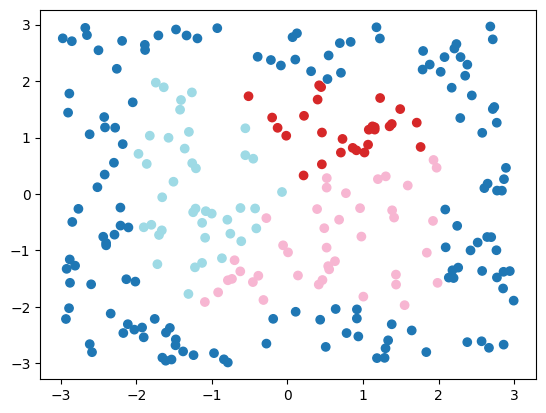

In [8]:
train_x, train_y, genfn = gen_data(250)
plt.scatter(train_x[:,0], train_x[:,1], c=train_y, cmap=cmap)

In [9]:
test_grid_size = 100
test_d1 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)
test_d2 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)), dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

torch.Size([100, 100])
(100, 100)


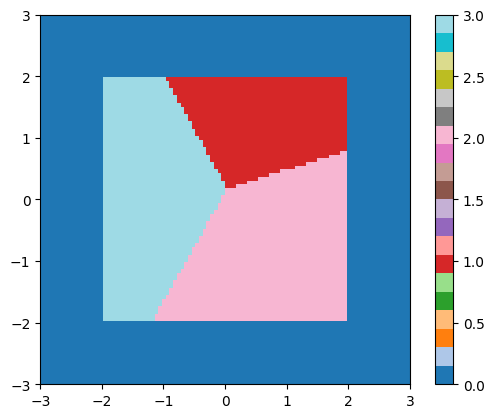

In [10]:
plt.imshow(test_labels, cmap=cmap, origin='lower', extent=[-3,3,-3,3])
plt.colorbar()


In [29]:
# from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [30]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(DirichletGPModel, self).__init__(inducing_points)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y.flatten(), learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [12]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 26.881   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 21.952   lengthscale: 0.974   noise: 0.967
Iter 11/50 - Loss: 18.535   lengthscale: 1.305   noise: 1.249
Iter 16/50 - Loss: 16.619   lengthscale: 1.639   noise: 1.495
Iter 21/50 - Loss: 15.616   lengthscale: 1.918   noise: 1.707
Iter 26/50 - Loss: 15.046   lengthscale: 2.120   noise: 1.886
Iter 31/50 - Loss: 14.686   lengthscale: 2.255   noise: 2.017
Iter 36/50 - Loss: 14.439   lengthscale: 2.344   noise: 2.088
Iter 41/50 - Loss: 14.259   lengthscale: 2.407   noise: 2.112
Iter 46/50 - Loss: 14.121   lengthscale: 2.456   noise: 2.113


In [13]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc
    pred_cov = likelihood(test_dist).stddev

In [14]:
pred_cov.shape

torch.Size([6, 10000])

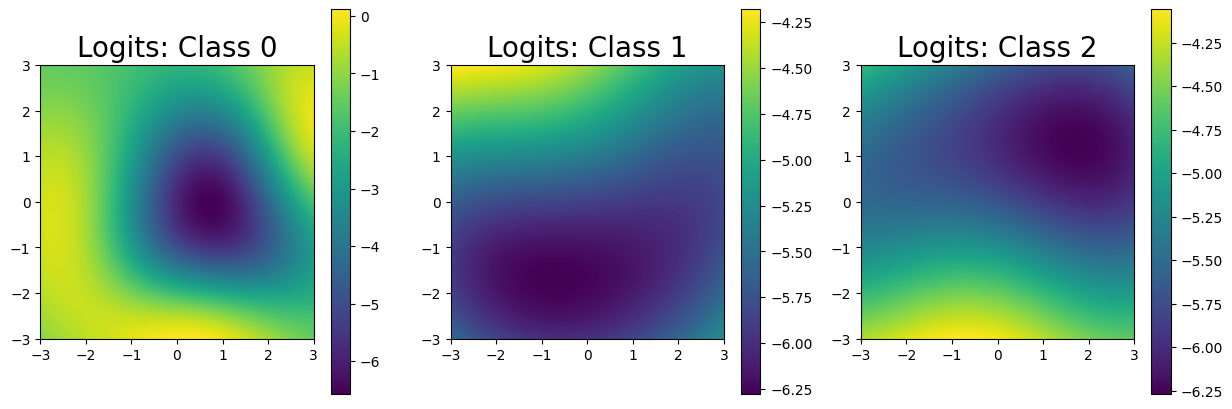

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    # im = ax[i].contourf(
    #     test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    # )
    im = ax[i].imshow(pred_means[i].numpy().reshape(test_grid_size,test_grid_size), origin='lower', extent=[-3,3,-3,3])
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)


In [16]:
pred_samples = test_dist.sample(torch.Size((64,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

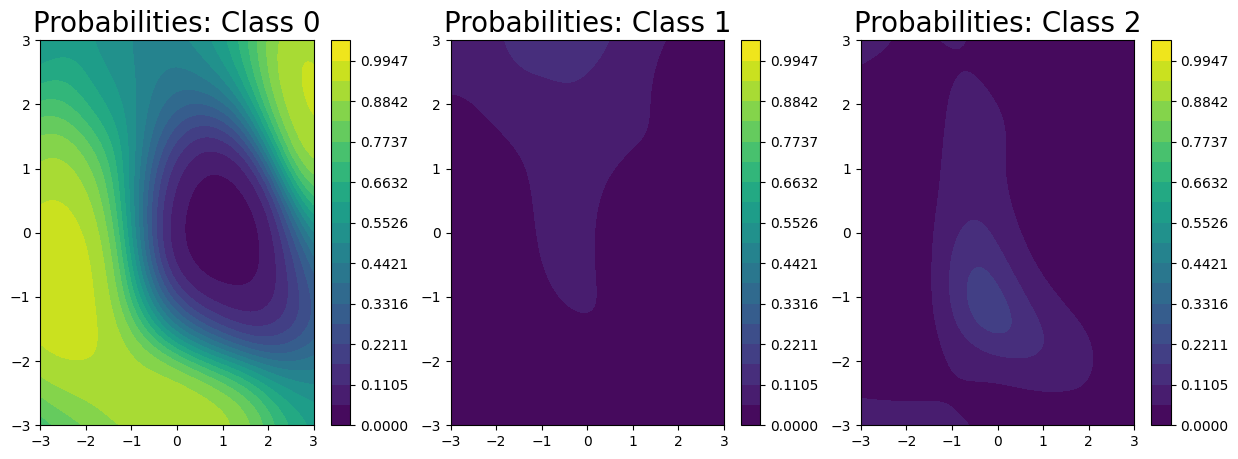

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((test_grid_size,test_grid_size)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Error: 38.10%


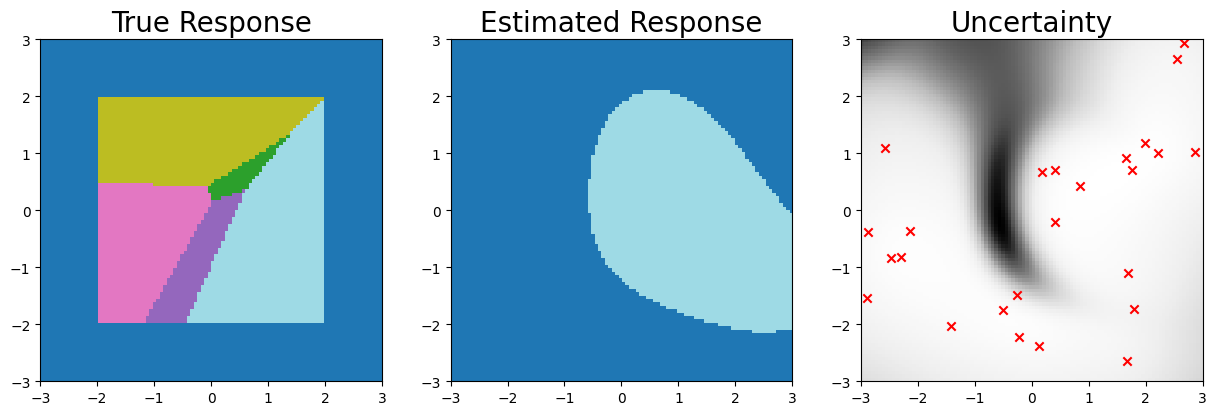

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(test_labels.numpy(), cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[0].set_title('True Response', fontsize=20)

prediction = pred_means.max(0)[1].reshape((test_grid_size,test_grid_size))
diff = test_labels.numpy() - pred_means.max(0)[1].reshape((test_grid_size,test_grid_size)).numpy()
ax[1].imshow(prediction, cmap=cmap, origin='lower', extent=[-3,3,-3,3])

ax[1].set_title('Estimated Response', fontsize=20)

# tot = np.ones((test_grid_size,test_grid_size))
tot = probabilities[0].numpy().reshape((test_grid_size,test_grid_size)) 
tot /= np.sum(tot)
for probability in probabilities[1:]:
    p = probability.numpy().reshape((test_grid_size,test_grid_size))
    tot *= p/np.sum(p)
p_pdf = tot/np.sum(tot)
pred_stddev = test_dist.stddev
stddev_pdf = pred_stddev.sum(0).detach().numpy().reshape((test_grid_size,test_grid_size))
# stddev_pdf -= stddev_pdf.min()
stddev_pdf /= stddev_pdf.sum()
tot = p_pdf + 3 * stddev_pdf
tot /= tot.sum()
ax[2].imshow(tot, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
ax[2].scatter(train_x[:,0], train_x[:,1], c='r', marker='x')
ax[2].set_title('Uncertainty', fontsize=20)
print(f"Error: {np.sum(np.clip(np.abs(diff),0,1))/test_grid_size**2:.2%}")


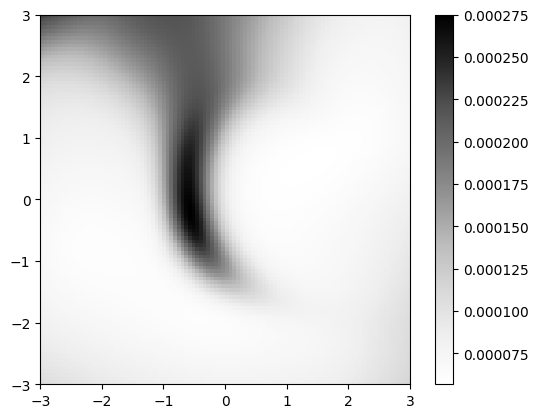

In [19]:
plt.imshow(tot, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
plt.colorbar()

In [20]:
max_uncertainty_index = np.unravel_index(tot.argmax(), tot.shape)
max_uncertainty_index

(46, 40)

In [23]:
test_grid_size = 100
test_d1 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)
test_d2 = np.linspace(-3, 3, test_grid_size, dtype=np.float32)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)), dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

torch.Size([100, 100])
(100, 100)


In [24]:
from predictor import fit, choose_next_position
# measured_positions = [
#     [-2.75,-2.75],
#     [-2.75,2.75],
#     [2.75,-2.75],
#     [2.75,2.75]
# ]
# measured_positions += np.random.uniform(-3,3,(6,2)).tolist()
measured_positions = np.random.uniform(-3,3,(1,2)).tolist()
measured_labels = [find_label(x,y) for x,y in measured_positions]
errors = []

while len(measured_positions) < 100:
    model = fit(
        torch.tensor(np.asarray(measured_positions, dtype=np.float32)),
        torch.tensor(np.asarray(measured_labels, dtype=int))
        )
    next_index, uncertainty_pdf = choose_next_position(model, test_x, measured_positions)
    new_x, new_y = test_x[next_index].numpy()
    measured_positions.append([new_x, new_y])
    measured_labels.append(find_label(new_x, new_y))
    if (not errors) or errors[-1] > 0.05:
        test_dist = model(test_x)
        pred_means = test_dist.loc
        pred_samples = test_dist.sample(torch.Size((256,))).exp()
        probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

        fig, ax = plt.subplots(1,3, figsize=(15, 5))

        ax[0].imshow(test_labels.numpy(), cmap=cmap, origin='lower', extent=[-3,3,-3,3])
        ax[0].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='k', marker='x')
        ax[0].set_title('True Response', fontsize=20)

        prediction = pred_means.max(0)[1].reshape((test_grid_size,test_grid_size))
        ax[1].imshow(prediction, cmap=cmap, origin='lower', extent=[-3,3,-3,3])
        ax[1].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='k', marker='x')
        ax[1].set_title('Estimated Response', fontsize=20)

        tot = uncertainty_pdf.reshape((test_grid_size,test_grid_size))
        ax[2].imshow(tot, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
        ax[2].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
        ax[2].set_title('Uncertainty', fontsize=20)
        ax[2].scatter(new_x, new_y, c='g', marker='o')
        diff = test_labels.numpy() != prediction.numpy()
        err = np.sum(diff)/len(diff)**2
        errors.append(err)
        fig.suptitle(f'Error: {err:.2%}', fontsize=20)
        print(f'{len(measured_positions)}: Error: {err:.2%}', end='\r')
        fig.savefig('figures/{}.png'.format(len(measured_positions)))
        plt.close(fig)


KeyboardInterrupt: 

In [ ]:
plt.plot(np.asarray(errors)*100)
plt.xlabel('Number of Measurements')
plt.ylabel('Error (%)')
plt.grid(which='both')
plt.xlim(0,40)
plt.ylim(0,50)
plt.savefig('error.png')


In [ ]:
test_dist = model(test_x)
pred_means = test_dist.loc
pred_samples = test_dist.sample(torch.Size((256,))).exp()
t_uncertainty = test_dist.stddev
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

In [ ]:
t_uncertainty.shape
t_img = t_uncertainty.mean(0).detach().numpy().reshape((test_grid_size,test_grid_size))
# t_img = t_uncertainty[0].detach().numpy().reshape((test_grid_size,test_grid_size))
t_img -= t_img.min()
t_img /= t_img.sum()

plt.imshow(t_img, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(test_labels.numpy(), cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[0].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[0].set_title('True Response', fontsize=20)

prediction = pred_means.max(0)[1].reshape((test_grid_size,test_grid_size))
diff = test_labels.numpy() - pred_means.max(0)[1].reshape((test_grid_size,test_grid_size)).numpy()
ax[1].imshow(prediction, cmap=cmap, origin='lower', extent=[-3,3,-3,3])
ax[1].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[1].set_title('Estimated Response', fontsize=20)

tot = uncertainty_pdf.reshape((test_grid_size,test_grid_size))
ax[2].imshow(t_img, origin='lower', extent=[-3,3,-3,3], cmap='Greys')
ax[2].scatter(np.asarray(measured_positions)[:,0], np.asarray(measured_positions)[:,1], c='r', marker='x')
ax[2].set_title('Uncertainty', fontsize=20)
ax[2].scatter(new_x, new_y, c='g', marker='o')
